Preprosses Data

In [ ]:
# import libraries
import numpy as np 
import pandas as pd
import os
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Conv2DTranspose,Reshape,ReLU,Conv2D,BatchNormalization,LeakyReLU,Flatten,Input
from tensorflow import keras
from tensorflow.keras.initializers import RandomNormal


In [ ]:
# Connect to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# define more usable parameters
IMAGE_SIZE = 64
CHANNEL = 3

In [ ]:
def resize_and_normal_images(image, label):
    temp = (tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))) / 255
    return temp

In [ ]:
def load_dataset(url_of_dataset):
  setattr(tfds.image_classification.cats_vs_dogs, '_URL',url_of_dataset)
  train, validation, test = tfds.load('cats_vs_dogs', split=['train[:70%]', 'train[70%:80%]', 'train[80%:]'], shuffle_files=True, as_supervised=True)
  train = train.map(resize_and_normal_images)
  validation = validation.map(map_func=resize_and_normal_images)
  test = test.map(map_func=resize_and_normal_images)
  train = np.array(list(train.as_numpy_iterator()))
  validation = np.array(list(validation.as_numpy_iterator()))
  test = np.array(list(test.as_numpy_iterator()))
  return train,validation,test

In [ ]:
url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
train,validation,test=load_dataset(url)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteP12665/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


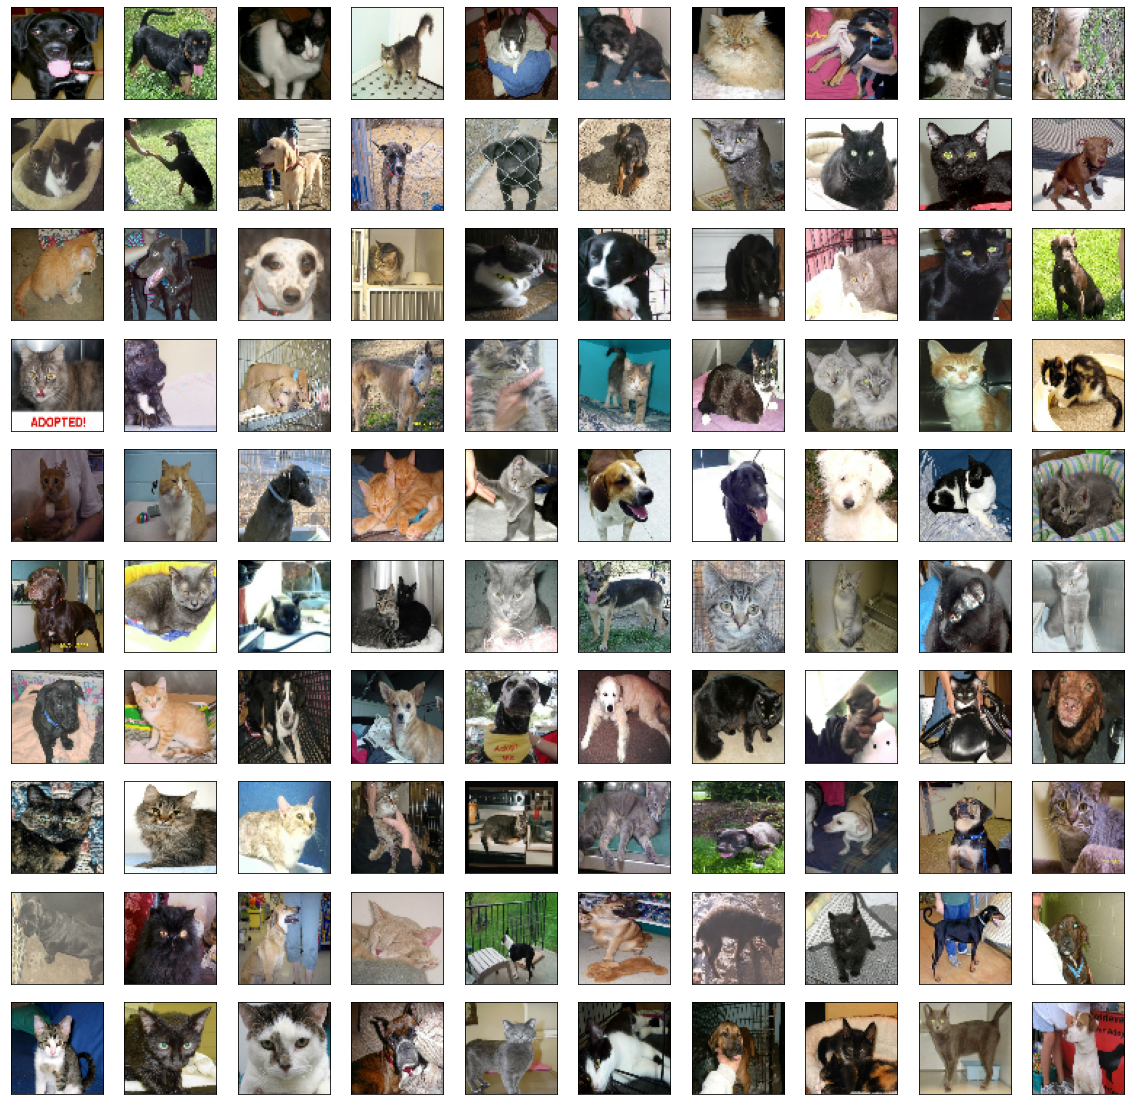

In [ ]:
# show 100 data of dataset
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10,10, i+1)
    plt.imshow(train[i+100].reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
# reduce size of train
train = train[:10000]
print(len(train))

FC_GAN

In [ ]:
def create_generator_FFNN(layers):
    model = Sequential()
    model.add(Input(shape=(IMAGE_SIZE,)))
    for layer in layers:
      model.add(layers.Dense(units=layer))
      model.add(layers.BatchNormalization(momentum=0.12,  epsilon=0.75))
      model.add(LeakyReLU(0.25))
    model.add(layers.Dense(IMAGE_SIZE*IMAGE_SIZE*CHANNEL, activation="tanh"))
    model.add(Reshape((IMAGE_SIZE,IMAGE_SIZE,CHANNEL)))
    return model

In [ ]:
def create_discriminator_FFNN(layers):
    model = Sequential()
    model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNEL)))
    model.add(Flatten())
    for layer in layers :
      model.add(Dense(layer))
      model.add(LeakyReLU(0.25))
    model.add(Dense(1,activation="sigmoid"))
    return model

In [ ]:
generator = create_generator_FFNN(layers = [128,256])
generator.compile(optimizer=keras.optimizers.Adam(0.0008 , 0.53),loss='binary_crossentropy')

In [ ]:
discriminator =create_discriminator_FFNN([512,256,128])
discriminator.compile(optimizer=keras.optimizers.Adam(0.0008 , 0.53),loss='binary_crossentropy')

In [ ]:
discriminator.trainable = False
input_size = keras.Input(shape=(IMAGE_SIZE,))
output = discriminator(generator(input_size))
gan = keras.models.Model(input_size, output)
gan.compile(optimizer=keras.optimizers.Adam(0.0008 , 0.53), loss='binary_crossentropy')
discriminator.trainable = True

In [ ]:
epochs = 110
batch_size = 256
save_dir = '/content/drive/MyDrive/Outputs_of_hw08/fc_normal_2'
start_pos_of_batch = 0
batch_len =int(len(train) / batch_size)
output_vector = np.random.normal(size=(100,IMAGE_SIZE))
loss_gan_array = []
loss_dis_array =[]

noize_rate = 0.75
mean = 0
var = 0.1

for epoch in range(epochs):
    loss_gan =0
    loss_dis =0
    for i in range(batch_len):
      input_of_generator = np.random.normal(size=(batch_size,IMAGE_SIZE))
      generated_images = generator.predict(input_of_generator)
      stop_pos_of_batch = start_pos_of_batch + batch_size
      real_images = train[start_pos_of_batch: stop_pos_of_batch]

      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(real_images.shape))
      noize_images = real_images + gauss

      merge_real_and_fake = np.concatenate([generated_images, noize_images])
      labels_real = np.concatenate([np.ones((batch_size, 1)),np.zeros((batch_size, 1))])
      
      d_loss = discriminator.train_on_batch(merge_real_and_fake, labels_real)
      labels_fake = np.zeros((batch_size, 1))
      g_loss = gan.train_on_batch(input_of_generator,labels_fake)
      loss_dis+= d_loss
      loss_gan+= g_loss
      start_pos_of_batch += batch_size
      
    start_pos_of_batch=0
    loss_gan= loss_gan/batch_len
    loss_dis = loss_dis/batch_len
    loss_gan_array.append(loss_gan)
    loss_dis_array.append(loss_dis)
    var *=noize_rate
    
    print(epoch)
    output_image = generator.predict(output_vector)
    print('discriminator loss:', loss_dis)
    print('gan loss:', loss_gan)
    plt.figure(figsize=(20, 20))
    for i in range(100):
        plt.subplot(10,10, i+1)
        plt.imshow(image.array_to_img(output_image[i] * 255., scale=False))
        plt.xticks([])
        plt.yticks([])
    plt.savefig(os.path.join(save_dir,'generated' + str(epoch) + '.png'))
    plt.clf()
        

0
discriminator loss: 0.72356594984348
gan loss: 0.5843965052030026
1
discriminator loss: 0.676184186568627
gan loss: 0.9135077712245476
2
discriminator loss: 0.666266951805506
gan loss: 0.7140819101761549
3
discriminator loss: 0.684209216099519
gan loss: 0.7620704475885782
4
discriminator loss: 1.0300885087404497
gan loss: 0.775374203880813
5
discriminator loss: 0.8991665014853845
gan loss: 1.0653907957230098
6
discriminator loss: 0.8364204642100211
gan loss: 0.5656906267007192
7
discriminator loss: 0.7051086639746641
gan loss: 0.6927292622052706
8
discriminator loss: 0.7100512308952136
gan loss: 0.7764810537680601
9
discriminator loss: 0.7051313167963272
gan loss: 0.8061025211444268
10
discriminator loss: 0.7257246436216892
gan loss: 0.9270065423005667
11
discriminator loss: 0.7124019891787798
gan loss: 0.8589555796904441
12
discriminator loss: 0.7056469993713574
gan loss: 0.8845961307867979
13
discriminator loss: 0.7676911033116854
gan loss: 0.9054188577410502
14
discriminator loss:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21
discriminator loss: 0.7019316722185184
gan loss: 1.0946301114864838
22
discriminator loss: 0.6973392764727274
gan loss: 0.9470913555377569
23
discriminator loss: 0.9108750529778309
gan loss: 1.190502218137949
24
discriminator loss: 0.7046206226715674
gan loss: 0.8358158255234743
25
discriminator loss: 0.6860333864505475
gan loss: 0.8346463510623345
26
discriminator loss: 0.7070755347227439
gan loss: 0.7872087420561374
27
discriminator loss: 0.6874126532138922
gan loss: 0.8147745529810587
28
discriminator loss: 0.6963397386746529
gan loss: 0.8116642378079586
29
discriminator loss: 0.692684775743729
gan loss: 0.8004899590443342
30
discriminator loss: 0.682208484564072
gan loss: 0.7703633736341428
31
discriminator loss: 0.6830169558525085
gan loss: 0.7924061921926645
32
discriminator loss: 0.6858042218746283
gan loss: 0.8186430300657566
33
discriminator loss: 0.7176725833843915
gan loss: 0.7921638947266799
34
discriminator loss: 0.7164093149014008
gan loss: 0.9161029901259985
35
discri

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

DC_GAN

In [1]:
def create_generator_CONOLUTIONAL(layers,input_shape= [4,4]):
    model = Sequential()
    model.add(Dense(input_shape[0]*input_shape[1]*256, kernel_initializer=RandomNormal(0, 0.025), input_dim=IMAGE_SIZE))
    model.add(ReLU())
    model.add(Reshape((input_shape[0], input_shape[1], 256)))
    for layer in layers:
        model.add(Conv2DTranspose(layer, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.025)))
        model.add(BatchNormalization(epsilon=0.75,momentum=0.15))
        model.add(ReLU())
    model.add(Conv2D(3, (CHANNEL, CHANNEL), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.025)))
    return model


In [ ]:
def create_discriminator_CONOLUTIONAL(layers,padding_in = "same",relu_param = 0.25,drop_out_param = 0.4):
    model = Sequential()
    model.add(layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL)))
    for layer in layers:
      model.add(Conv2D(layer, (CHANNEL, CHANNEL), padding=padding_in, kernel_initializer=RandomNormal(0, 0.025)))
      model.add(LeakyReLU(relu_param))
    model.add(Flatten())
    model.add(Dropout(drop_out_param))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
generator = create_generator_CONOLUTIONAL([256,256,256,256])
generator.compile(optimizer=keras.optimizers.Adam(0.0008 , 0.53),loss='binary_crossentropy')

In [ ]:
discriminator =create_discriminator_CONOLUTIONAL([256,128,128,64])
discriminator.compile(optimizer=keras.optimizers.Adam(0.0008 , 0.53),loss='binary_crossentropy')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       7168      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 256)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       295040    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
discriminator.trainable = False
input_size = keras.Input(shape=(IMAGE_SIZE,))
output = discriminator(generator(input_size))
gan = keras.models.Model(input_size, output)
gan.compile(optimizer=keras.optimizers.Adam(0.0008 , 0.53), loss='binary_crossentropy')
discriminator.trainable = True

In [ ]:
epochs = 110
batch_size = 256
save_dir = '/content/drive/MyDrive/Outputs_of_hw08/dc_normal_2'
start_pos_of_batch = 0
batch_len =int(len(train) / batch_size)
output_vector = np.random.normal(size=(100,IMAGE_SIZE))
loss_gan_array = []
loss_dis_array =[]

noize_rate = 0.75
mean = 0
var = 0.1

for epoch in range(epochs):
    loss_gan =0
    loss_dis =0
    for i in range(batch_len):
      input_of_generator = np.random.normal(size=(batch_size,IMAGE_SIZE))
      generated_images = generator.predict(input_of_generator)
      stop_pos_of_batch = start_pos_of_batch + batch_size
      real_images = train[start_pos_of_batch: stop_pos_of_batch]

      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(real_images.shape))
      noize_images = real_images + gauss

      merge_real_and_fake = np.concatenate([generated_images, noize_images])
      labels_real = np.concatenate([np.ones((batch_size, 1)),np.zeros((batch_size, 1))])
      
      d_loss = discriminator.train_on_batch(merge_real_and_fake, labels_real)
      labels_fake = np.zeros((batch_size, 1))
      g_loss = gan.train_on_batch(input_of_generator,labels_fake)
      loss_dis+= d_loss
      loss_gan+= g_loss
      start_pos_of_batch += batch_size
      
    start_pos_of_batch=0
    loss_gan= loss_gan/batch_len
    loss_dis = loss_dis/batch_len
    loss_gan_array.append(loss_gan)
    loss_dis_array.append(loss_dis)
    var *=noize_rate
    
    print(epoch)
    output_image = generator.predict(output_vector)
    print('discriminator loss:', loss_dis)
    print('gan loss:', loss_gan)
    plt.figure(figsize=(20, 20))
    for i in range(100):
        plt.subplot(10,10, i+1)
        plt.imshow(image.array_to_img(output_image[i] * 255., scale=False))
        plt.xticks([])
        plt.yticks([])
    plt.savefig(os.path.join(save_dir,'generated' + str(epoch) + '.png'))
    plt.clf()
        

0
discriminator loss: 0.6944650006599915
gan loss: 1.5783506662417681
1
discriminator loss: 0.7641179454632294
gan loss: 1.5339541610998986
2
discriminator loss: 0.640277813642453
gan loss: 2.0920461347469916
3
discriminator loss: 0.678009419869154
gan loss: 1.2162347548665144
4
discriminator loss: 0.7841969170631506
gan loss: 0.8980731214396656
5
discriminator loss: 0.686523315234062
gan loss: 0.7788612789068466
6
discriminator loss: 0.7169656310326014
gan loss: 1.0596636537557993
7
discriminator loss: 0.6575490037600199
gan loss: 0.8097034975504264
8
discriminator loss: 0.6682235033084185
gan loss: 0.8388554293375748
9
discriminator loss: 0.7173799841831892
gan loss: 0.7774570979751073
10
discriminator loss: 1.0141895902462494
gan loss: 1.0345366247571433
11
discriminator loss: 0.6777173540531061
gan loss: 0.8381818020955111
12
discriminator loss: 0.6863071628105946
gan loss: 0.731114523533063
13
discriminator loss: 0.6658624716294117
gan loss: 0.778090082682096
14
discriminator loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21
discriminator loss: 0.618926444878945
gan loss: 1.0156769469762459
22
discriminator loss: 0.6328939482187613
gan loss: 0.9424811937870123
23
discriminator loss: 0.6184570437822586
gan loss: 1.0103735717443318
24
discriminator loss: 0.5721353147274408
gan loss: 1.0105138405775413
25
discriminator loss: 142.11601052299525
gan loss: 278.81351441681505
26
discriminator loss: 3.2793657305913095
gan loss: 4.402752792527537
27
discriminator loss: 1.0491733023753533
gan loss: 3.4679896097916822
28
discriminator loss: 0.5651175333903387
gan loss: 3.493214637805254
29
discriminator loss: 0.4505069523285597
gan loss: 3.2026423521530933
30
discriminator loss: 0.5498000253469516
gan loss: 2.496271552183689
31
discriminator loss: 0.42944805515118134
gan loss: 2.0063657454955273
32
discriminator loss: 0.36308365754592115
gan loss: 2.095102955133487
33
discriminator loss: 0.38648395584179807
gan loss: 2.1584689005827293
34
discriminator loss: 0.3706272840499878
gan loss: 2.2070658084673758
35
discr